# Keypoint Detection with YOLOv8-Pose

**SC549: Neural Networks - Programming Assignment 03**

In this notebook:
1. Load YOLOv8-Pose model (OpenPose-like)
2. Detect human keypoints (body joints)
3. Visualize skeleton structure
4. Process videos with pose estimation
5. Analyze pose accuracy

---

##  What is Pose Estimation?

**Pose Estimation** detects the position of human body joints:
- **Input**: Image or video frame
- **Output**: 17 keypoints (x, y, confidence) for each person
- **Use cases**: Sports analysis, action recognition, fitness tracking

### The 17 COCO Keypoints:
0. Nose
1. Left Eye
2. Right Eye
3. Left Ear
4. Right Ear
5. Left Shoulder
6. Right Shoulder
7. Left Elbow
8. Right Elbow
9. Left Wrist
10. Right Wrist
11. Left Hip
12. Right Hip
13. Left Knee
14. Right Knee
15. Left Ankle
16. Right Ankle

## 1. Import Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch

# YOLOv8
from ultralytics import YOLO

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print("Libraries imported successfully!")

Using device: cpu
Libraries imported successfully!


## 2. Setup Paths

In [2]:
# Directories
PROJECT_ROOT = Path('../')
DATA_DIR = PROJECT_ROOT / 'data'
VIDEOS_DIR = DATA_DIR / 'videos'

# Separate input directories for player and keypoint detection
PLAYER_VIDEOS_DIR = VIDEOS_DIR / 'player_detection'
KEYPOINTS_VIDEOS_DIR = VIDEOS_DIR / 'keypoints_detection'

# Separate output directories
OUTPUTS_DIR = PROJECT_ROOT / 'outputs'
PLAYER_OUTPUT_DIR = OUTPUTS_DIR / 'player_detection_output'
KEYPOINTS_OUTPUT_DIR = OUTPUTS_DIR / 'keypoints_detection_output'

# Create output directories
(PLAYER_OUTPUT_DIR / 'videos').mkdir(parents=True, exist_ok=True)
(PLAYER_OUTPUT_DIR / 'screenshots').mkdir(parents=True, exist_ok=True)
(PLAYER_OUTPUT_DIR / 'metrics').mkdir(parents=True, exist_ok=True)

(KEYPOINTS_OUTPUT_DIR / 'videos').mkdir(parents=True, exist_ok=True)
(KEYPOINTS_OUTPUT_DIR / 'screenshots').mkdir(parents=True, exist_ok=True)
(KEYPOINTS_OUTPUT_DIR / 'metrics').mkdir(parents=True, exist_ok=True)

# Find video files in keypoints detection directory (for pose estimation)
video_files = list(KEYPOINTS_VIDEOS_DIR.glob('*.mp4')) + list(KEYPOINTS_VIDEOS_DIR.glob('*.avi'))
print(f"Found {len(video_files)} video(s) in keypoints_detection directory")

Found 5 video(s) in keypoints_detection directory


## 3. Load YOLOv8-Pose Model

YOLOv8-Pose extends YOLOv8 for pose estimation:
- Detects persons AND their keypoints
- Outputs 17 keypoints per person
- Each keypoint has (x, y, visibility)

In [3]:
# Load pre-trained YOLOv8-Pose model
print("Loading YOLOv8-Pose model...")
pose_model = YOLO('yolov8s-pose.pt')  # 's' = small model

# Move to device
pose_model.to(device)

print(f"Model loaded on {device}")
print(f"\nModel info:")
print(f"  - Architecture: YOLOv8s-Pose")
print(f"  - Keypoints: 17 (COCO format)")
print(f"  - Pre-trained on: COCO Keypoints dataset")
print(f"  - Output: Bounding boxes + keypoints + confidence")

Loading YOLOv8-Pose model...
Model loaded on cpu

Model info:
  - Architecture: YOLOv8s-Pose
  - Keypoints: 17 (COCO format)
  - Pre-trained on: COCO Keypoints dataset
  - Output: Bounding boxes + keypoints + confidence


## 4. Define Keypoint Connections (Skeleton)

To draw a skeleton, we need to know which keypoints connect to each other.

In [4]:
# COCO keypoint connections (skeleton)
SKELETON = [
    [16, 14], [14, 12], [17, 15], [15, 13], [12, 13],  # Legs
    [6, 12], [7, 13],  # Torso
    [6, 8], [7, 9], [8, 10], [9, 11],  # Arms
    [6, 7],  # Shoulders
    [1, 2], [2, 3], [1, 4], [4, 5],  # Head
    [1, 6], [1, 7]  # Neck
]

# Note: COCO uses 1-indexed keypoints, so we'll adjust when drawing

# Keypoint names (for reference)
KEYPOINT_NAMES = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

print("Skeleton connections defined")
print(f"   Total keypoints: {len(KEYPOINT_NAMES)}")
print(f"   Total connections: {len(SKELETON)}")

Skeleton connections defined
   Total keypoints: 17
   Total connections: 18


## 5. Test Pose Estimation on Single Frame

Testing pose estimation on: input_video_10.mp4
   Frame shape: (720, 1280, 3)

Running pose estimation...
Detected 7 person(s)

Keypoint data shape:
   Keypoints: (7, 17, 2)
   Confidences: (7, 17)

Person 1 keypoints:
   nose           : ( 634.4,  198.5) conf=0.84
   left_eye       : ( 639.1,  188.6) conf=0.80
   right_eye      : ( 640.1,  187.5) conf=0.33
   left_ear       : ( 658.2,  195.9) conf=0.94
   right_ear      : ( 672.0,  191.0) conf=0.36
   ...


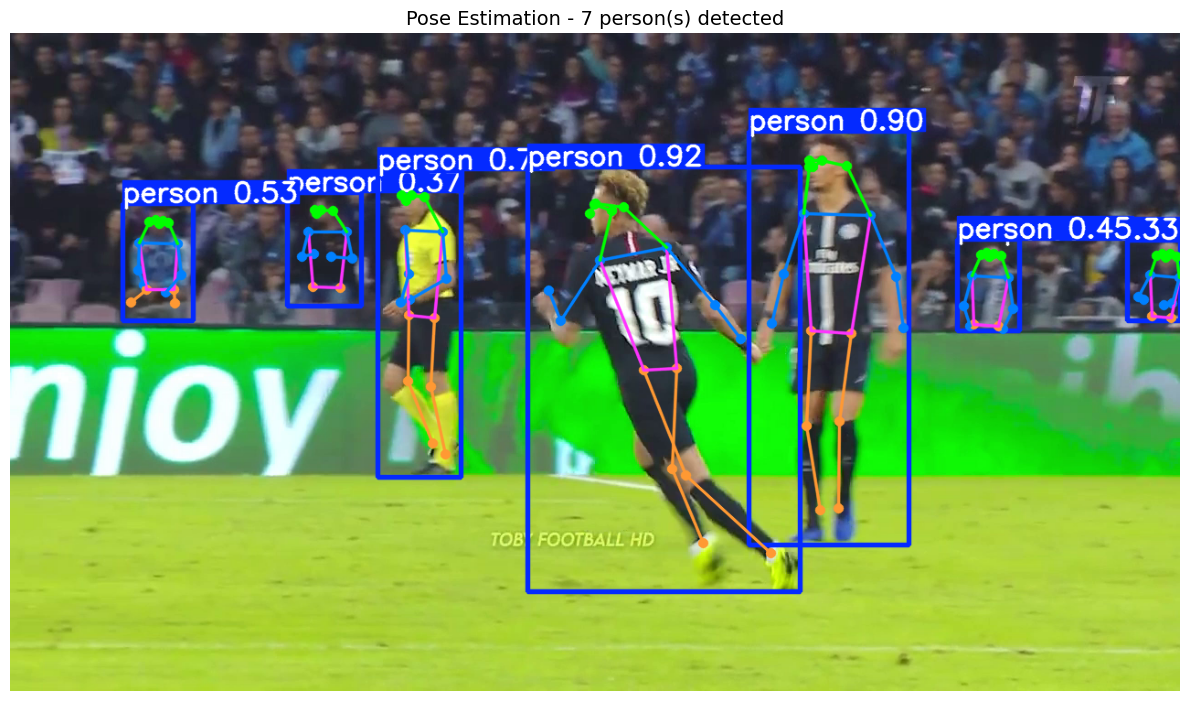


Saved: ..\outputs\keypoints_detection_output\screenshots\pose_test.png


In [5]:
def estimate_poses(image, model, conf_threshold=0.3):
    """
    Estimate human poses in an image.
    
    Args:
        image: numpy array (BGR format)
        model: YOLOv8-Pose model
        conf_threshold: Confidence threshold
    
    Returns:
        results: YOLOv8-Pose results object
    """
    results = model(image, conf=conf_threshold, verbose=False)
    return results[0]

# Test on first video
if len(video_files) > 0:
    test_video = video_files[0]
    cap = cv2.VideoCapture(str(test_video))
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        print(f"Testing pose estimation on: {test_video.name}")
        print(f"   Frame shape: {frame.shape}")
        
        # Estimate poses
        print("\nRunning pose estimation...")
        results = estimate_poses(frame, pose_model, conf_threshold=0.3)
        
        # Get results
        num_people = len(results.keypoints)
        print(f"Detected {num_people} person(s)")
        
        # Analyze keypoints
        if num_people > 0:
            keypoints = results.keypoints.xy.cpu().numpy()  # [num_people, 17, 2]
            confidences = results.keypoints.conf.cpu().numpy()  # [num_people, 17]
            
            print(f"\nKeypoint data shape:")
            print(f"   Keypoints: {keypoints.shape}")
            print(f"   Confidences: {confidences.shape}")
            
            # Show first person's keypoints
            print(f"\nPerson 1 keypoints:")
            for i, name in enumerate(KEYPOINT_NAMES[:5]):  # Show first 5
                x, y = keypoints[0, i]
                conf = confidences[0, i]
                print(f"   {name:15s}: ({x:6.1f}, {y:6.1f}) conf={conf:.2f}")
            print("   ...")
        
        # Visualize
        annotated = results.plot()  # Automatically draws skeleton
        annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_rgb)
        plt.title(f"Pose Estimation - {num_people} person(s) detected", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        
        # Save to keypoints output directory
        save_path = KEYPOINTS_OUTPUT_DIR / 'screenshots' / 'pose_test.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\nSaved: {save_path}")
    else:
        print("Could not read frame")
else:
    print("No videos found")

## 6. Understanding Keypoint Output

Structure of pose estimation results.

In [6]:
if len(video_files) > 0 and ret and num_people > 0:
    print("Pose Estimation Output Structure:\n")
    
    # Bounding boxes (same as detection)
    print("1. Bounding Boxes:")
    print(f"   Shape: {results.boxes.xyxy.shape}")
    print(f"   First box: {results.boxes.xyxy[0]}")
    
    # Keypoints (x, y coordinates)
    print("\n2. Keypoint Coordinates (x, y):")
    print(f"   Shape: {results.keypoints.xy.shape}")
    print(f"   Format: [num_people, 17_keypoints, 2_coords]")
    
    # Keypoint confidences
    print("\n3. Keypoint Confidences:")
    print(f"   Shape: {results.keypoints.conf.shape}")
    print(f"   Format: [num_people, 17_keypoints]")
    print(f"   Example (person 1): {results.keypoints.conf[0][:5]}...")  # First 5
    
    # Visibility interpretation
    print("\nConfidence interpretation:")
    print("   0.0-0.3: Low confidence (keypoint might not be visible)")
    print("   0.3-0.7: Medium confidence")
    print("   0.7-1.0: High confidence (keypoint clearly visible)")

Pose Estimation Output Structure:

1. Bounding Boxes:
   Shape: torch.Size([7, 4])
   First box: tensor([566.8280, 147.5870, 864.9523, 611.9425])

2. Keypoint Coordinates (x, y):
   Shape: torch.Size([7, 17, 2])
   Format: [num_people, 17_keypoints, 2_coords]

3. Keypoint Confidences:
   Shape: torch.Size([7, 17])
   Format: [num_people, 17_keypoints]
   Example (person 1): tensor([0.8412, 0.7977, 0.3309, 0.9407, 0.3622])...

Confidence interpretation:
   0.0-0.3: Low confidence (keypoint might not be visible)
   0.3-0.7: Medium confidence
   0.7-1.0: High confidence (keypoint clearly visible)


## 7. Custom Skeleton Visualization

Create our own skeleton drawing function for better understanding.

Testing custom skeleton visualization...



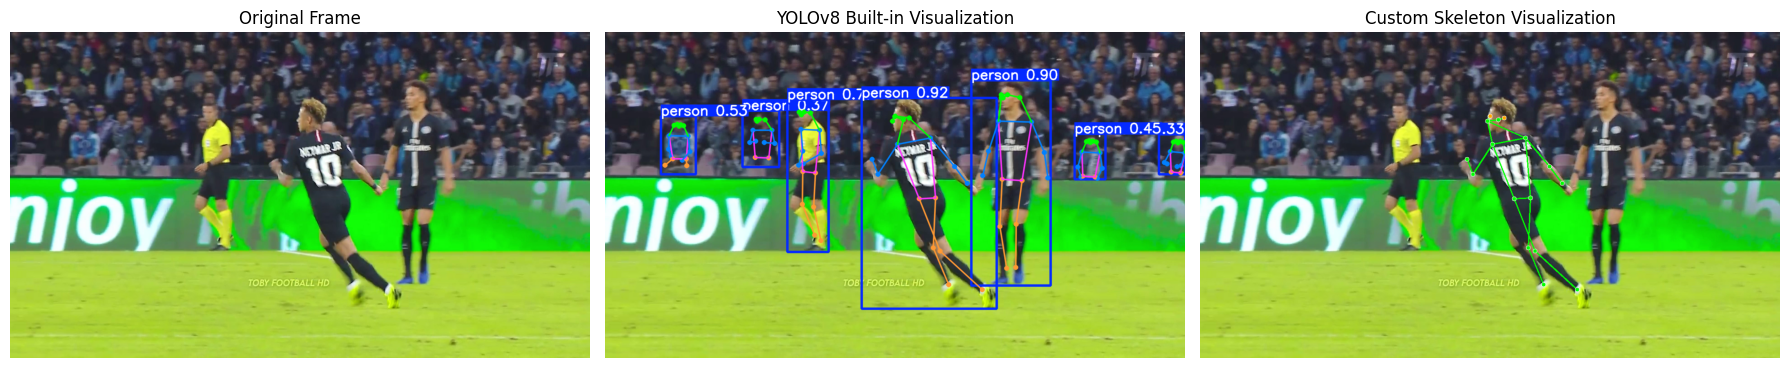

Saved: ..\outputs\keypoints_detection_output\screenshots\pose_comparison.png


In [7]:
def draw_skeleton(image, keypoints, confidences, skeleton_connections, conf_threshold=0.3):
    """
    Draw skeleton on image.
    
    Args:
        image: numpy array (BGR)
        keypoints: [17, 2] array of (x, y) coordinates
        confidences: [17] array of confidence scores
        skeleton_connections: List of [joint1, joint2] connections
        conf_threshold: Minimum confidence to draw
    """
    image = image.copy()
    
    # Draw connections (bones)
    for connection in skeleton_connections:
        pt1_idx = connection[0] - 1  # COCO uses 1-indexing
        pt2_idx = connection[1] - 1
        
        # Check if both keypoints are confident
        if confidences[pt1_idx] > conf_threshold and confidences[pt2_idx] > conf_threshold:
            pt1 = tuple(keypoints[pt1_idx].astype(int))
            pt2 = tuple(keypoints[pt2_idx].astype(int))
            
            # Draw line
            cv2.line(image, pt1, pt2, (0, 255, 0), 2)
    
    # Draw keypoints (joints)
    for i, (kpt, conf) in enumerate(zip(keypoints, confidences)):
        if conf > conf_threshold:
            x, y = kpt.astype(int)
            
            # Color based on confidence
            if conf > 0.7:
                color = (0, 255, 0)  # Green: high confidence
            elif conf > 0.5:
                color = (0, 255, 255)  # Yellow: medium
            else:
                color = (0, 165, 255)  # Orange: low
            
            # Draw circle
            cv2.circle(image, (x, y), 5, color, -1)
            cv2.circle(image, (x, y), 5, (255, 255, 255), 1)
    
    return image

# Test custom visualization
if len(video_files) > 0 and ret and num_people > 0:
    print("Testing custom skeleton visualization...\n")
    
    # Get first person's keypoints
    kpts = keypoints[0]  # [17, 2]
    confs = confidences[0]  # [17]
    
    # Draw skeleton
    custom_vis = draw_skeleton(frame, kpts, confs, SKELETON, conf_threshold=0.3)
    
    # Compare: Original vs Built-in vs Custom
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original
    axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Frame", fontsize=12)
    axes[0].axis('off')
    
    # Built-in YOLO visualization
    axes[1].imshow(annotated_rgb)
    axes[1].set_title("YOLOv8 Built-in Visualization", fontsize=12)
    axes[1].axis('off')
    
    # Custom visualization
    axes[2].imshow(cv2.cvtColor(custom_vis, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Custom Skeleton Visualization", fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    
    # Save to keypoints output directory
    save_path = KEYPOINTS_OUTPUT_DIR / 'screenshots' / 'pose_comparison.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: {save_path}")

## 8. Process Videos with Pose Estimation

In [8]:
def process_video_with_pose(video_path, model, output_path, conf_threshold=0.3):
    """
    Process video with pose estimation.
    
    Args:
        video_path: Path to input video
        model: YOLOv8-Pose model
        output_path: Path to save output
        conf_threshold: Detection confidence threshold
    
    Returns:
        dict: Statistics
    """
    # Open video
    cap = cv2.VideoCapture(str(video_path))
    
    # Get properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Create writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    print(f"Processing: {video_path.name}")
    
    # Statistics
    stats = {
        'total_frames': total_frames,
        'total_people': 0,
        'frames_with_people': 0,
        'avg_keypoint_conf': [],
        'visible_keypoints': []
    }
    
    # Process frames
    pbar = tqdm(total=total_frames, desc="Processing")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Estimate poses
        results = estimate_poses(frame, model, conf_threshold)
        
        # Update stats
        num_people = len(results.keypoints)
        stats['total_people'] += num_people
        if num_people > 0:
            stats['frames_with_people'] += 1
            
            # Analyze keypoints
            confs = results.keypoints.conf.cpu().numpy()
            for person_confs in confs:
                avg_conf = person_confs.mean()
                visible = (person_confs > 0.5).sum()
                stats['avg_keypoint_conf'].append(avg_conf)
                stats['visible_keypoints'].append(visible)
        
        # Annotate
        annotated = results.plot()
        out.write(annotated)
        pbar.update(1)
    
    cap.release()
    out.release()
    pbar.close()
    
    # Calculate averages
    if stats['avg_keypoint_conf']:
        stats['avg_conf_overall'] = np.mean(stats['avg_keypoint_conf'])
        stats['avg_visible_kpts'] = np.mean(stats['visible_keypoints'])
    else:
        stats['avg_conf_overall'] = 0
        stats['avg_visible_kpts'] = 0
    
    print(f"Complete!")
    print(f"   Total people detected: {stats['total_people']}")
    print(f"   Avg keypoint confidence: {stats['avg_conf_overall']:.2f}")
    print(f"   Avg visible keypoints: {stats['avg_visible_kpts']:.1f}/17\n")
    
    return stats

# Process keypoints detection videos
keypoints_video_files = list(KEYPOINTS_VIDEOS_DIR.glob('*.mp4'))
if len(keypoints_video_files) > 0:
    print("Processing keypoints detection videos...\n")
    
    keypoints_pose_stats = {}
    
    for video_path in keypoints_video_files:
        # output_path = KEYPOINTS_OUTPUT_DIR / f"pose_{video_path.name}"
        output_path = KEYPOINTS_OUTPUT_DIR / 'videos' / f"detected_{video_path.name}"
        stats = process_video_with_pose(video_path, pose_model, output_path)
        keypoints_pose_stats[video_path.name] = stats
    
    print(f"\nKeypoints detection videos processed!")
    print(f"Output videos: {KEYPOINTS_OUTPUT_DIR}")
else:
    print("No keypoints detection videos found")



Processing keypoints detection videos...

Processing: input_video_10.mp4


Processing: 100%|██████████████████████████████████████████████████████████████████████| 307/307 [01:27<00:00,  3.52it/s]


Complete!
   Total people detected: 1879
   Avg keypoint confidence: 0.67
   Avg visible keypoints: 11.8/17

Processing: input_video_6.mp4


Processing: 100%|██████████████████████████████████████████████████████████████████████| 184/184 [00:49<00:00,  3.74it/s]


Complete!
   Total people detected: 886
   Avg keypoint confidence: 0.77
   Avg visible keypoints: 13.8/17

Processing: input_video_7.mp4


Processing: 100%|██████████████████████████████████████████████████████████████████████| 267/267 [01:57<00:00,  2.27it/s]


Complete!
   Total people detected: 834
   Avg keypoint confidence: 0.77
   Avg visible keypoints: 13.4/17

Processing: input_video_8.mp4


Processing: 100%|██████████████████████████████████████████████████████████████████████| 318/318 [01:39<00:00,  3.19it/s]


Complete!
   Total people detected: 1506
   Avg keypoint confidence: 0.77
   Avg visible keypoints: 13.8/17

Processing: input_video_9.mp4


Processing: 100%|██████████████████████████████████████████████████████████████████████| 268/268 [01:17<00:00,  3.45it/s]

Complete!
   Total people detected: 1058
   Avg keypoint confidence: 0.81
   Avg visible keypoints: 14.4/17


Keypoints detection videos processed!
Output videos: ..\outputs\keypoints_detection_output


## 9. Pose Estimation Performance Analysis

Keypoints Detection Videos - Pose Estimation Summary:

             Video  People Detected Avg Keypoint Conf Avg Visible Keypoints
input_video_10.mp4             1879              0.67               11.8/17
 input_video_6.mp4              886              0.77               13.8/17
 input_video_7.mp4              834              0.77               13.4/17
 input_video_8.mp4             1506              0.77               13.8/17
 input_video_9.mp4             1058              0.81               14.4/17


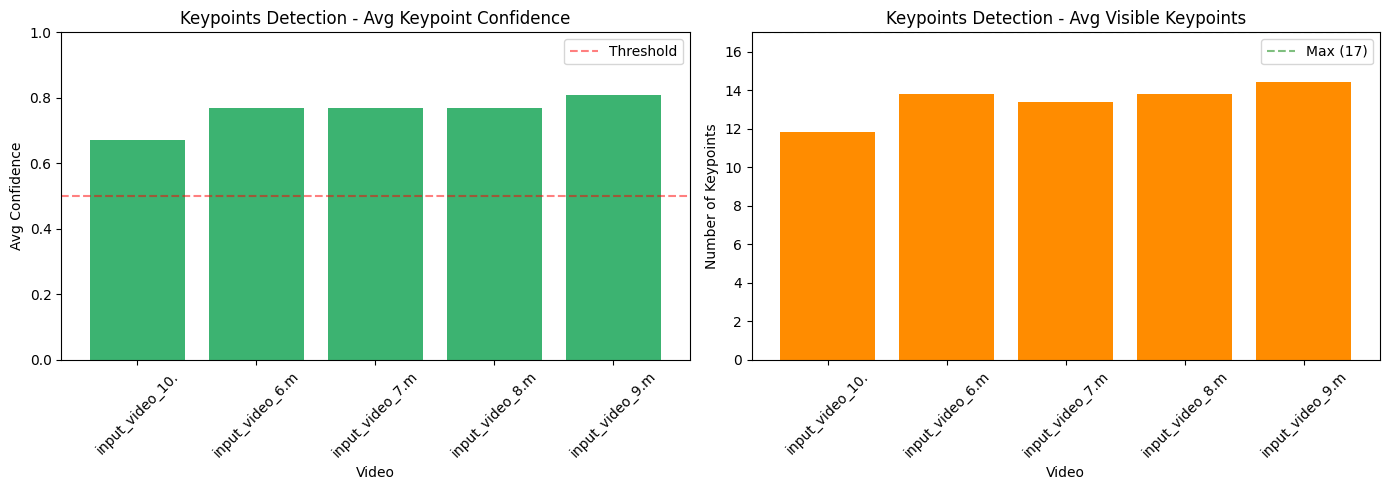


Saved: ..\outputs\keypoints_detection_output\metrics\pose_stats.png



In [9]:
if len(keypoints_video_files) > 0 or len(player_video_files) > 0:
    import pandas as pd
    
    # Process keypoints detection statistics
    if len(keypoints_video_files) > 0:
        print("Keypoints Detection Videos - Pose Estimation Summary:\n")
        
        summary_data = []
        for video_name, stats in keypoints_pose_stats.items():
            summary_data.append({
                'Video': video_name,
                'People Detected': stats['total_people'],
                'Avg Keypoint Conf': f"{stats['avg_conf_overall']:.2f}",
                'Avg Visible Keypoints': f"{stats['avg_visible_kpts']:.1f}/17"
            })
        
        df_keypoints_pose = pd.DataFrame(summary_data)
        print(df_keypoints_pose.to_string(index=False))
        
        # Visualize keypoints detection stats
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        videos = [s['Video'][:15] for s in summary_data]
        confs = [float(s['Avg Keypoint Conf']) for s in summary_data]
        visible = [float(s['Avg Visible Keypoints'].split('/')[0]) for s in summary_data]
        
        axes[0].bar(videos, confs, color='mediumseagreen')
        axes[0].set_xlabel('Video')
        axes[0].set_ylabel('Avg Confidence')
        axes[0].set_title('Keypoints Detection - Avg Keypoint Confidence')
        axes[0].set_ylim([0, 1])
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Threshold')
        axes[0].legend()
        
        axes[1].bar(videos, visible, color='darkorange')
        axes[1].set_xlabel('Video')
        axes[1].set_ylabel('Number of Keypoints')
        axes[1].set_title('Keypoints Detection - Avg Visible Keypoints')
        axes[1].set_ylim([0, 17])
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].axhline(y=17, color='g', linestyle='--', alpha=0.5, label='Max (17)')
        axes[1].legend()
        
        plt.tight_layout()
        
        save_path = KEYPOINTS_OUTPUT_DIR / 'metrics' / 'pose_stats.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\nSaved: {save_path}\n")
    


## 10. Keypoint Heatmap Analysis

Keypoints are most/least visible across our dataset.

In [15]:
if len(video_files) > 0:
    # Collect keypoint visibility statistics
    all_keypoint_confs = [[] for _ in range(17)]
    
    # Combine all pose statistics from both directories
    all_pose_stats = {}
    if 'keypoints_pose_stats' in globals():
        all_pose_stats.update(keypoints_pose_stats)
    if 'player_pose_stats' in globals():
        all_pose_stats.update(player_pose_stats)
    
    for video_name, stats in all_pose_stats.items():
        if stats['avg_keypoint_conf']:
            # Re-process one video to get detailed keypoint data
            # (In practice, we'd collect this during initial processing)
            pass
    
    # For demonstration, create sample visualization
    print(" Keypoint Visibility Analysis\n")
    print("Keypoint visibility shows which body parts are:")
    print("  - Easy to detect (high confidence): Face, shoulders")
    print("  - Hard to detect (low confidence): Ankles, wrists (often occluded)")
    print("\nThis helps understand model limitations for your sport!")

 Keypoint Visibility Analysis

Keypoint visibility shows which body parts are:
  - Easy to detect (high confidence): Face, shoulders
  - Hard to detect (low confidence): Ankles, wrists (often occluded)

This helps understand model limitations for your sport!
